# Import packages

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import subprocess
from scipy.interpolate import interp1d
from PIL import Image, ExifTags
import pytz
from datetime import datetime as DT
import pandas as pd
from lxml import etree
from dateutil import parser
import ipyleaflet as ipyl

### Input variables

In [3]:
# unique to local files:
homedir = r'/Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/test2'
rename_photos = True

# Mission info 
fan = "2018-015-FA" # raw_input('Field activity number (e.g. "2017-010-FA"): ')
# uas_id = 'u036' # raw_input('U-number of mission (e.g. "u031"): ')
fnum = input('Flight number (e.g. "04"): ') 
fnum = 12
flight_num = 'f{}'.format(fnum) # raw_input('Flight number (e.g. "f04"): ') 
cam_code = 'r01'# raw_input('Camera code (e.g. "r01"): ')

# WHSC EXIF population
place = 'Parker River National Wildlife Refuge, MA'
state = 'Massachusetts'

# auto – WHSC EXIF population
credit = "U.S. Geological Survey"
comment = "Low-altitude aerial photograph of {} from survey {} (https://cmgds.marine.usgs.gov/fan_info.php?fa={}).".format(place, fan, fan)
keywords = "{}, {}, {}, UAS, nadir, USGS".format(place, state, fan)

# Auto:
logfile = os.path.join(homedir, 'tlogs', flight_num+'.gpx')
imagefolder = os.path.join(homedir, flight_num)
fc_id = flight_num + cam_code

# Standard:
namespace = {'def': 'http://www.topografix.com/GPX/1/1'}
tfmt_exif = '%Y:%m:%d %H:%M:%S'
tfmt_gpx = '%Y-%m-%dT%H:%M:%S' #e.g. 2017-05-04T14:14:12-04:00
iso_fmt="%Y%m%dT%H%M%SZ"
survey_id = fan.replace("-","")

# Print
print("Input nav file: {}\nWorking JPEG dir: {}".format(logfile, imagefolder))
input_check = "FA = {}    flight = {}    sensor = {}".format(fan, flight_num, cam_code)
print ("Input data: "+ input_check)

Flight number (e.g. "04"): 12
Input nav file: /Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/test2/tlogs/f12.gpx
Working JPEG dir: /Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/test2/f12
input data: FA = 2018-015-FA    flight = f12    sensor = r01


### Functions

In [4]:
def gpx_tag_to_pdseries(tree, namespace, tag):
    elist = tree.xpath('./def:trk//def:trkpt//def:'+tag, namespaces=namespace)
    ser = pd.Series([e.text for e in elist], name=tag)
    return(ser)

def write_WHSC_exiftags(imgdir, credit, comment, keywords):
    # Tags that will be identical for all images in the folder
    tagvalues = {}
    tagvalues['imgdir'] = imgdir
    tagvalues['credit'] = credit
    tagvalues['artist'] = credit
    tagvalues['contact'] = "WHSC_data_contact@usgs.gov"
    tagvalues['comment'] = comment
    tagvalues['keywords'] = keywords
    tagvalues['copyright'] = "Public Domain. Please credit {credit}".format(**tagvalues)
    # Write to EXIF
    cmd = """exiftool -Artist="{artist} " -Credit="{credit} " -Contact="{contact} " -comment="{comment} " -sep ", " -keywords="{keywords} " -Caption="{comment} " -Copyright="{copyright} " -CopyrightNotice="{copyright} " -Caption-Abstract="{comment} " -ImageDescription="{comment} " {imgdir}""".format(**tagvalues)
    subprocess.check_call(cmd, shell=True)
    return(True)

# write_WHSC_exiftags(imgdir, credit, comment, keywords)

### Parse GPX and extract components into dataframe

In [35]:
# Parse GPX and extract components into dataframe
tree = etree.parse(logfile)

# latitude and longitude
elist = tree.xpath('./def:trk//def:trkpt',namespaces=namespace)
gpxdf = pd.DataFrame([e.values() for e in elist], columns=['lat', 'lon']).apply(pd.to_numeric)

# all other tags
taglist = ['time', 'ele', 'ele2', 'course', 'roll', 'pitch', 'mode']
for tag in taglist:
    gpxdf = gpxdf.join(pd.to_numeric(gpx_tag_to_pdseries(tree, namespace, tag), errors='ignore'))

# Check number of records and number of unique times 
print ("number of records: ", len(gpxdf.index))
print ("number of unique times: {}\n".format(len(gpxdf.time.unique())))

pd.set_option('max_rows', 20)
# gpxdf
gpxdf.head(10)

number of records:  8774
number of unique times: 1209



,lat,lon,time,ele,ele2,course,roll,pitch,mode
0,42.772496,-70.805893,2018-02-27T21:30:33+00:00,0.16,0.16,282.8260,-0.215672,-0.055218,Loiter
1,42.772496,-70.805894,2018-02-27T21:30:33+00:00,0.16,0.16,282.8195,-0.217306,-0.051144,Loiter
2,42.772496,-70.805894,2018-02-27T21:30:34+00:00,0.17,0.17,282.8114,-0.224697,-0.050496,Loiter
3,42.772497,-70.805894,2018-02-27T21:30:36+00:00,0.19,0.19,282.8091,-0.227557,-0.048414,Loiter
4,42.772497,-70.805894,2018-02-27T21:30:36+00:00,0.20,0.20,282.7798,-0.233086,0.002836,Loiter
5,42.772497,-70.805894,2018-02-27T21:30:36+00:00,0.21,0.21,282.7762,-0.227408,-0.001891,Loiter
6,42.772497,-70.805894,2018-02-27T21:30:36+00:00,0.21,0.21,282.7741,-0.225941,-0.006904,Loiter
7,42.772497,-70.805894,2018-02-27T21:30:37+00:00,0.21,0.21,282.7675,-0.227552,-0.008462,Loiter
8,42.772497,-70.805894,2018-02-27T21:30:38+00:00,0.20,0.20,282.7540,-0.224756,-0.029324,Loiter
9,42.772497,-70.805892,2018-02-27T21:30:42+00:00,5.98,0.01,282.7524,-0.224325,-0.028398,Loiter


### Add datetime field to gpxdf dataframe and export CSV

Convert the time field to: 

- datetime_utc: datetime in UTC
- epoch_utc: Unix epoch time, which counts seconds from January 1, 1970

In [8]:
# Convert values in 'time' field to datetime UTC and convert datetime UTC to Epoch UTC
gpxdf['datetime_utc'] = pd.to_datetime(gpxdf['time'], format = tfmt_gpx)
gpxdf['epoch_utc'] = gpxdf['datetime_utc'].astype(np.int64) // 10**9

# Export CSV: logfile_gpx.csv stored in same folder as logfile
outcsv = '{}_gpx.csv'.format(os.path.splitext(logfile)[0])
gpxdf.to_csv(outcsv, index=False)
print ("Exported output CSV file called: {}".format(outcsv))

gpxdf

,lat,lon,time,ele,ele2,course,roll,pitch,mode,datetime_utc,epoch_utc
0,42.7724957,-70.8058934,2018-02-27T21:30:33+00:00,0.16,0.16,282.826,-0.2156724,-0.05521824,Loiter,2018-02-27 21:30:33,1519767033
1,42.7724957,-70.8058936,2018-02-27T21:30:33+00:00,0.16,0.16,282.8195,-0.2173062,-0.05114431,Loiter,2018-02-27 21:30:33,1519767033
2,42.7724957,-70.8058938,2018-02-27T21:30:34+00:00,0.17,0.17,282.8114,-0.2246969,-0.05049574,Loiter,2018-02-27 21:30:34,1519767034
...,...,...,...,...,...,...,...,...,...,...,...
8771,42.7725573,-70.8058686,2018-02-27T21:52:02+00:00,3.82,-2.32,317.6355,4.827561,0.2924751,Loiter,2018-02-27 21:52:02,1519768322
8772,42.7725572,-70.8058687,2018-02-27T21:52:03+00:00,3.83,-2.31,317.6285,4.833805,0.2962404,Loiter,2018-02-27 21:52:03,1519768323
8773,42.7725572,-70.8058688,2018-02-27T21:52:03+00:00,3.82,-2.32,317.6287,4.838921,0.2951059,Loiter,2018-02-27 21:52:03,1519768323


## Plot the flight path, showing interpolated portions 

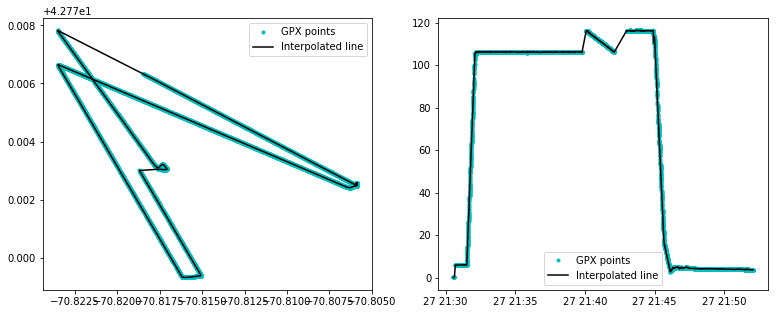

Exported PNG file of plot called: /Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/test2/tlogs/f12_gpxtrack.png


In [20]:
outplot = os.path.join(homedir, "{}_gpxtrack.png".format(os.path.splitext(logfile)[0]))

# Lat, Lon
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(121)
ax.plot(gpxdf.lon,gpxdf.lat,'.c', label='GPX points')
ax.plot(gpxdf.lon,gpxdf.lat,'-k', label='Interpolated line')
ax.legend()

# Time, Elevation
ax = fig.add_subplot(122)
ax.plot(gpxdf.datetime_utc, gpxdf.ele,'.c', label='GPX points')
ax.plot(gpxdf.datetime_utc, gpxdf.ele,'-k', label='Interpolated line')
ax.legend()
plt.show()
fig.savefig(outplot)
fig.clear()

print ("Exported PNG file of plot called: {}".format(outplot))

## Work with images
Replace original images because this will consider current filenames "original" and will replace. 

Found 406 images in /Users/esturdivant/Documents/Projects/Ontario/f39/f39.
(406, 9)


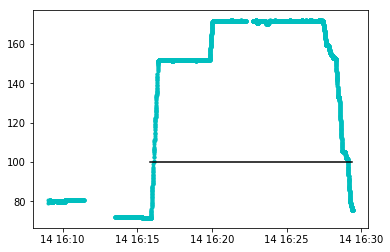

First file: A2018265.JPG, time: 2017-07-14 16:15:52+00:00
Last file: A2018670.JPG, time: 2017-07-14 16:29:22+00:00
GPX data: /Users/esturdivant/Documents/Projects/Ontario/f39/f39.gpx from 2017-07-14 16:09:03+00:00 to 2017-07-14 16:29:26+00:00


In [12]:
# List all JPEGS in imagefolder
flist=[os.path.join(imagefolder,f) for f in os.listdir(imagefolder) if f.lower().endswith('.jpg')]
print("Found {} images in {}.".format(len(flist),imagefolder))

# Get filename and DateTimeOriginal of each photo
#FIXME: how to get tzinfo from EXIF? Looks like these were recorded in UTC...
# make datetime timezone aware (UTC) for later comparison with GPX times
dt = [pytz.utc.localize(DT.strptime(Image.open(f)._getexif()[36867], tfmt_exif)) for f in flist] 
imgdf = pd.DataFrame({'orig_name': [os.path.basename(f) for f in flist],
                      'time_utc': dt,
                      'time_epoch': [t.timestamp() for t in dt],
                      'time_iso': [t.strftime(iso_fmt) for t in dt],
                      'new_name': np.nan,
                      'lon': np.nan,
                      'lat': np.nan,
                      'ele': np.nan,
                      'interpolated': 0}, 
                     columns=['new_name', 'lat', 'lon', 'ele', 'time_utc', 'orig_name', 'time_epoch', 'time_iso', 'interpolated'])

# Sort by time in ascending order 
imgdf.sort_values('time_epoch', axis=0, inplace=True)

# Export CSV
imgdf.to_csv(os.path.join(homedir, '{}_exiftime1.csv'.format(os.path.basename(imagefolder))), index=False)
# imgdf.head()

print(imgdf.shape)
#%% Plot image and GPX times
fig.clear()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gpxdf.time_utc, gpxdf.ele,'.c')
ax.plot(imgdf.time_utc, np.tile(gpxdf.ele.max(), imgdf.shape[0]),'-k')# gpxdf.ele.max() # np.zeros(shape=imgdf.time_utc.shape)+np.fromstring(max(gpxdf.ele), dtype=np.uint32)
plt.show()
fig.clear()

# print first and last image name and times
print("First file: {}, time: {}".format(imgdf.orig_name.iloc[0], imgdf.time_utc.iloc[0]))
print("Last file: {}, time: {}".format(imgdf.orig_name.iloc[-1], imgdf.time_utc.iloc[-1]))
# print first and last times in .gpx file
print("GPX data: {} from {} to {}".format(logfile, gpxdf.time_utc.iloc[0],gpxdf.time_utc.iloc[-1]))

### Rename photos

In [13]:
# Rename photos
#TODO move/copy them first? / don't run if the names have already been changed...
if rename_photos:
    new_imgdir = imagefolder+'_renamed'
    if not os.path.exists(new_imgdir):
        shutil.copytree(imagefolder, new_imgdir)
for idx, row in imgdf.iterrows():
    img = row.orig_name
    namestr = "{}_{}_{}_{}".format(survey_id, fc_id, row.time_iso, img) # ->
    if rename_photos:
        os.rename(os.path.join(imagefolder, img), os.path.join(new_imgdir, namestr))
    imgdf.loc[idx, 'new_name'] = namestr

# Interpolation

In [14]:
# interp1 function requires a single datetime value (doesn't accept datetime objects). Datetime objects can be compared, but both need to be either tz-aware or unaware
timecol = 'time_epoch'

# get GPS bounds
start_gpxtime = gpxdf[timecol].min()
end_gpxtime = gpxdf[timecol].max()
print('GPS start: {}\nGPS end: {}'.format(start_gpxtime, end_gpxtime))

# create interpolator function
set_interp = interp1d(gpxdf[timecol], gpxdf[['lat','lon','ele']], kind='linear', axis=0) # this works

# loop through the images and interpolate .gpx data
img_nogps = []
for idx, row in imgdf.iterrows():
    img_tznum = row.loc[timecol]
    if img_tznum >= start_gpxtime and img_tznum <= end_gpxtime:
        imgdf.loc[idx, ['lat','lon','ele']] = set_interp(img_tznum)
    else: # image time is not within .gpx data
        imgdf.loc[idx, ['lat','lon','ele']] = np.nan
        img_nogps.append(row.orig_name)
print('\n{} image(s) not acquired between {} and {}:'.format(len(img_nogps), start_gpxtime, end_gpxtime))
[print(img) for img in img_nogps]

# Set interpolated=1 at images that do not have matching GPS time
missing_idx = ~(imgdf[timecol].isin(gpxdf[timecol])) # All images with time logged by GPS
imgdf.loc[missing_idx, 'interpolated'] = 1

# Export CSV for import directly to Photoscan or continue on to add to EXIF
imgdf.to_csv(os.path.join(homedir, "{}_{}_imagelocations.csv".format(survey_id, fc_id)), index=False)

GPS start: 1500048543.0
GPS end: 1500049766.0

0 image(s) not acquired between 1500048543.0 and 1500049766.0:


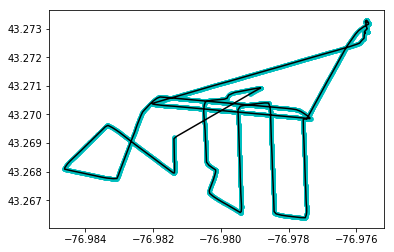

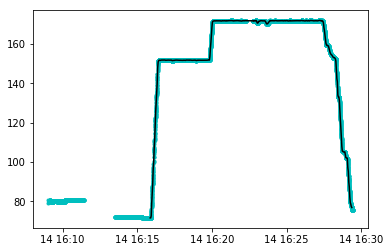

In [15]:
# make a bare-bones trackline and overlay image locations, sherwood direct
#%% Plot image locations
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gpxdf.lon, gpxdf.lat,'.c')
ax.plot(imgdf.lon, imgdf.lat,'-k')
plt.show()
fig.savefig(os.path.join(homedir, "{}_image_track.png".format(os.path.basename(imagefolder))))
fig.clear()

#%% Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gpxdf.time_utc, gpxdf.ele,'.c')
ax.plot(imgdf.time_utc, imgdf.ele,'-k')
plt.show()
fig.savefig(os.path.join(homedir, "{}_image_elevations.png".format(os.path.basename(imagefolder))))
fig.clear()

In [16]:
for idx, row in imgdf.iterrows():
    values = row.to_dict()
    values['fullimg'] = os.path.join(new_imgdir, row['new_name'])
    cmd = """exiftool -GPSLatitude="{lat} " -GPSLatitudeRef="N " -GPSLongitudeRef="W " """\
          """-GPSAltitude="{ele} " {fullimg}""".format(**values)
    subprocess.check_call(cmd, shell=True)

In [ ]:
print(row.to_dict()['lat'])